<a href="https://colab.research.google.com/github/Andrey-Mel/predict_game_cards/blob/main/Predict_game_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Импорт библиотек

In [ ]:
!apt-get -qq install -y convolutional

E: Unable to locate package convolutional


In [ ]:
from tensorflow.keras.models import Sequential, Model #сети
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input, Reshape #базовые слои 
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import utils #утилиты для to_categorical
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping

import numpy as np
import random                                                                          
import matplotlib.pyplot as plt #для отрисовки графиков при обучении
from PIL import Image #для отрисовки изображений
import os #для работы с файлами
from google.colab import files #для загрузки файлов

%matplotlib inline

In [ ]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/deks_cards.zip' -d /content

In [ ]:
train_path_rang = '/content/deks_cards/rang'
train_path_suit = '/content/deks_cards/suit'
batch_size = 56
img_height = 110
img_width = 76
channel = 3

In [ ]:
for i in range(3):
  rang_path = train_path_rang + '/' + os.listdir(train_path_rang)[i] + '/'
  print(rang_path)

/content/deks_cards/rang/6_J/
/content/deks_cards/rang/8_K/
/content/deks_cards/rang/4_9/


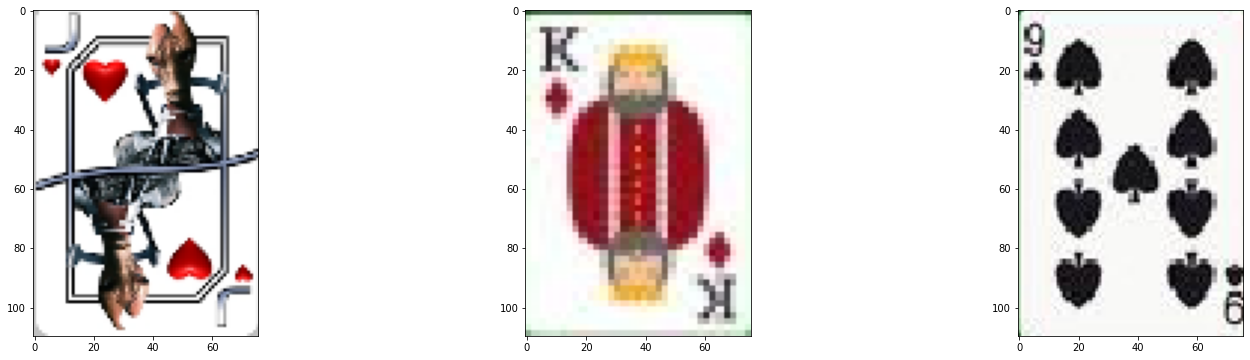

In [ ]:
#Проверяю подключение к рангам карт и отображаю
fig, axs = plt.subplots(1, 3, figsize=(25,6))
for i in range(3):
  rang_path = train_path_rang + '/' + os.listdir(train_path_rang)[i] + '/'
  rang_card_path = rang_path + random.choice(os.listdir(rang_path))
  axs[i].imshow(image.load_img(rang_card_path, target_size=(img_height, img_width)))  
plt.show()

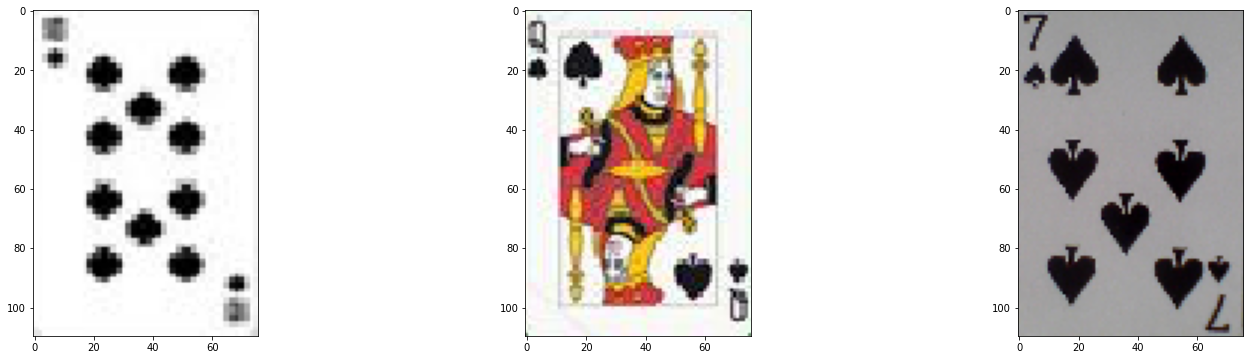

In [ ]:
#Проверяю подключение к мастям карт и отображаю
fig, axs = plt.subplots(1,3, figsize=(25,6))
for i in range(3):

  suit_path = train_path_suit + '/' + os.listdir(train_path_suit)[1] + '/'
  suit_card_path = suit_path + random.choice(os.listdir(suit_path))
  axs[i].imshow(image.load_img(suit_card_path, target_size=(img_height, img_width)))
plt.show()
  

In [ ]:
#Генератор изображений из кераса
datagen = ImageDataGenerator(
    rescale =1. / 255, #заменяем цвета на дробные показания
    rotation_range = 10, #поворачиваем изображения при генерации выборки
    width_shift_range = 0.1, #двигаем  изображения по ширине при генерации выборки
    height_shift_range = 0.1, #двигаем изображения по высоте при генерации выборки
    zoom_range = 0.1, #зумируем изображения при генерации выборки
    horizontal_flip = True, #включаем отзеркаливание изображений
    fill_mode = 'nearest', #запонение пиклселей вне границ ввода
    validation_split = 0.15 # указываем разделение изображение на обучающую и тестовую выборки
)

**ШАГ 1. Эта часть по форимированию генератора изображений по ДОСТОИНСТВАМ карт и НЕЙРОСЕТЬ по распознаванию достоинства карт.**

In [ ]:
#обучающая выборка по достоинствам карт
rang_train_gen = datagen.flow_from_directory(
    train_path_rang, #путь ко всей выборке
    target_size = (img_height,img_width),#размер изображений
    batch_size=batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training' #устанавливаем как набор для обучения
)

Found 1784 images belonging to 9 classes.


In [ ]:
#проверочная выборка по достоинствам карт
rang_val_gen = datagen.flow_from_directory(
    train_path_rang,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 306 images belonging to 9 classes.


In [ ]:
rang_train_gen.class_indices

{'1_6': 0,
 '2_7': 1,
 '3_8': 2,
 '4_9': 3,
 '5_10': 4,
 '6_J': 5,
 '7_Q': 6,
 '8_K': 7,
 '9_A': 8}

In [ ]:
#Cоздаю список достоинства карт для понимания правильности предсказания. В таком же порядке очередности достоинств карт и сформированной базе.
#Поэтому я считаю что это будет правильный ответ предсказания
rang_list = ['6','7','8','9','10','J','Q','K','A']

In [ ]:
#Создаю callback для удобства сохранения нужных весов
rang_callback = ModelCheckpoint(filepath = '/content/drive/MyDrive/model_rang/v.2_weights-{epoch:02d}-{val_accuracy:2f}+lr=000000023.h5',
                                monitor = 'val_accuracy',
                                verbose = 0,
                                save_best_only = True,
                                save_weights_only = True,
                                mode = 'max',
                                save_freq = 'epoch')

In [ ]:
#Создаю функцию создания нейросети
def rang_model(input_shape=(img_height,img_width,channel)):
  input_img = Input(input_shape)#110,76,3
  x = Conv2D(256,(3,3), padding='same')(input_img)#110,76,256
  x = Conv2D(256,(3,3), padding='same')(x)#110,76,256
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)

  x = MaxPooling2D()(x)#55,38,256

  x = Conv2D(128,(3,3),padding='same')(x)#55,38,128
  x = Conv2D(128,(3,3),padding='same')(x)#55,38,128
  x = LeakyReLU()(x)

  x = Conv2D(64,(2,2),padding='same')(x)#55,38,64.     512
  x = Conv2D(64,(2,2),padding='same')(x)#55,38,64      512
  x = LeakyReLU()(x)

  x = MaxPooling2D()(x)#27.5,19,64

  x = Conv2D(128,(3,3),padding='same')(x)#27.5,19,128
  x = LeakyReLU()(x)
  x = Dropout(0.15)(x)

  x = Conv2D(128,(3,3),padding='same')(x)#27.5,19,128
  x = LeakyReLU()(x)
  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(1024)(x)
  x = LeakyReLU()(x)
  #выходной слой

  # input_img = Input(input_shape)#110,76,3
  # x = Conv2D(256,(3,3), padding='same')(input_img)#110,76,256
  # #x = BatchNormalization()(input_img)
  # x = Conv2D(256,(3,3), padding='same')(x)
  # x = LeakyReLU()(x)
  # x = Conv2D(256,(3,3), padding='same')(x)#110,76,256
  # x = LeakyReLU()(x)
  # #x = BatchNormalization()(x)
  # x = Dropout(0.1)(x)

  # x = MaxPooling2D()(x)#55,38,256

  # x = Conv2D(128,(3,3),padding='same')(x)#55,38,128
  # x = LeakyReLU()(x)
  # x = Conv2D(128,(3,3),padding='same')(x)#55,38,128
  # x = LeakyReLU()(x)

  # x = Conv2D(64,(2,2),padding='same')(x)#55,38,64
  # x = LeakyReLU()(x)
  # x = Conv2D(64,(2,2),padding='same')(x)#55,38,64
  # x = LeakyReLU()(x)
  # x = Dropout(0.1)(x)

  # x = MaxPooling2D()(x)#27.5,19,64

  # x = Conv2D(128,(3,3),padding='same')(x)#27.5,19,128
  # x = LeakyReLU()(x)
  # x = Dropout(0.15)(x)
  # x = Conv2D(128,(3,3),padding='same')(x)#27.5,19,128
  # x = LeakyReLU()(x)
  # x = Dropout(0.3)(x)

  # x = Flatten()(x)
  # x = Dense(1024)(x)
  # x = LeakyReLU()(x)
  # #выходной слой
  x = Dense(len(rang_train_gen.class_indices), activation='softmax')(x)

  model = Model(input_img,x)

  #Компилирую
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

  return model



In [ ]:
#Создаю модель по обучению достоинства карт
rang_card_model = rang_model((img_height,img_width,channel))

In [ ]:
#сохранение модели на гугл диск
rang_card_model.save('/content/drive/My Drive/model_rang/rang_card_model.h5')

In [ ]:
rang_card_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.000000023), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/120
31/31 [==============================] - 14s 418ms/step - loss: 0.3455 - accuracy: 0.8789 - val_loss: 0.3367 - val_accuracy: 0.8643
Epoch 2/120
31/31 [==============================] - 14s 435ms/step - loss: 0.3333 - accuracy: 0.8908 - val_loss: 0.3552 - val_accuracy: 0.8643
Epoch 3/120
31/31 [==============================] - 13s 427ms/step - loss: 0.2876 - accuracy: 0.9144 - val_loss: 0.3894 - val_accuracy: 0.8536
Epoch 4/120
31/31 [==============================] - 13s 411ms/step - loss: 0.3072 - accuracy: 0.8896 - val_loss: 0.3319 - val_accuracy: 0.9036
Epoch 5/120
31/31 [==============================] - 13s 410ms/step - loss: 0.3287 - accuracy: 0.8822 - val_loss: 0.3588 - val_accuracy: 0.8857
Epoch 6/120
31/31 [==============================] - 13s 405ms/step - loss: 0.3238 - accuracy: 0.8802 - val_loss: 0.2881 - val_accuracy: 0.9071
Epoch 7/120
31/31 [==============================] - 13s 421ms/step - loss: 0.2887 - accuracy: 0.8917 - val_loss: 0.3219 - val_accuracy:

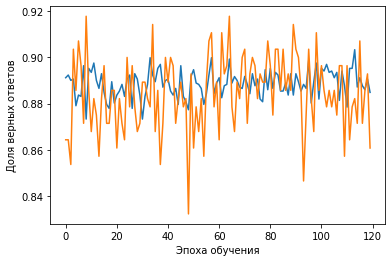

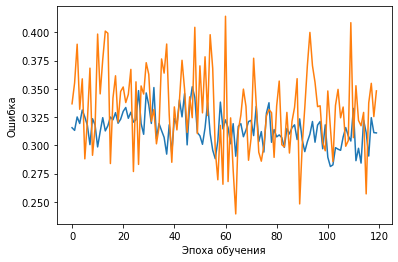

In [ ]:
history_r = rang_card_model.fit_generator(
    rang_train_gen,
    steps_per_epoch = rang_train_gen.samples // batch_size,
    validation_data = rang_val_gen,
    validation_steps = rang_val_gen.samples // batch_size,
    epochs = 120,
    callbacks = [rang_callback],
    verbose = 1
)


#графики
plt.plot(history_r.history['accuracy'], label = 'Доля верных ответов на обучающей выборке')
plt.plot(history_r.history['val_accuracy'], label='Доля верных ответов на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

plt.plot(history_r.history['loss'], label = 'Ошибка на обучающей выборке')
plt.plot(history_r.history['val_loss'], label='Ошибка на проверочной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.show()

По данным в обучении сети лучший val_accuracy = 0.92, но по графику видно что нужно дообучать. Дообучить я хочу после того как сформирую полностью с распознаванием и масти карты, выложить уже в одну карту и дообучить, ведь веса сохраняются

In [ ]:
#rang_card_model.save_weights('/content/drive/MyDrive/model_rang/rang_card_model.h5')
rang_card_model.load_weights('/content/drive/MyDrive/model_rang/v.2_weights-02-0.932143+lr=0.0000000013.h5')
#rang_card_model.load_weights('/content/drive/MyDrive/model_rang/weights-12-0.928571+lr0.00000025.h5')

## --------- Для ДЗ 35 tensorflowservig-------------------------------------------------

In [ ]:
#Сохраню модель для ДЗ занятия 35 в формате SavedModel для теста Tensorflow Serving
MODEL_DIR = '/content/our_model' #создание временной директории для хранения модели
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print("Путь экспорта = {}\n".format(export_path))

Путь экспорта = /content/our_model/1



In [ ]:
import tensorflow as tf

In [ ]:
#Сохраняю модель в формате SavedModel
tf.keras.models.save_model(
    rang_card_model,
    export_path,
    overwrite = True,
    include_optimizer=True,
    save_format=None,
    signatures = None,
    options=None
)

print('\nСохраненная модель: ')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /content/our_model/1/assets

Сохраненная модель: 
total 316
drwxr-xr-x 2 root root   4096 Feb 14 11:19 assets
-rw-r--r-- 1 root root 314956 Feb 14 11:19 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb 14 11:19 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 110, 76, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 9)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Traceback (most recent call last):
  File "/usr/local/bin/saved_model_cli", line 8, in <module>
    sys.exit(main())
  File "/usr/l

## -----------------------------------------------------------------

**Распознавание достоинства карты**

In [ ]:
def what_rang(name_card, model,img_height = 110,img_width = 76, channel = 3):
  img = image.load_img(name_card,target_size = (img_height, img_width,channel))
  np_img = np.array(img) / 255
  plt.imshow(np_img)
  plt.show()
  
  #Predict
  rang_list = ['6','7','8','9','10','J','Q','K','A']
  
  predict_rang = model.predict(np_img[None,])[0]  
  rang = rang_list[np.argmax(predict_rang)]
  print()
  print(predict_rang)
  
  tmp = predict_rang[np.argmax(predict_rang)]
  if tmp <0.91:
    print('Эту карту я незнаю, положите другую.')
  print()
  print(tmp)
  print()
  print(rang)



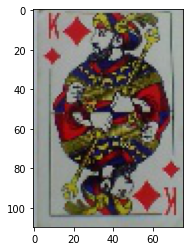


[2.0083719e-14 1.7082364e-13 4.9633119e-14 1.7682753e-11 1.3222342e-11
 2.3082511e-03 4.5885444e-03 9.9310315e-01 7.6876155e-08]

0.99310315

K


In [ ]:
what_rang('K_diamond57.jpg',rang_card_model)

Вывод по распознаванию достоинства карт таков, что если карт в выборке небыло модель распознает не точно. Если карты которые были в выборке, то модель распознает карту (по данным argmaxa) на 99.9%. Вот карта которая сейчас на экране нейронка распознала как Туз, наверное много пустого пространства как в тузах.

**ШАГ 2. Формирование данных для генератора, но путь к базе где собраны все масти карт и буду обучать сеть для распознавания масти карт. Затем объединю модель по распознаванию достоинства и распознавания масти карт в одну функцию, которая будет выводить полностью карту:достоинство + масть**.

In [ ]:
#Переопределю batch_size
batch_size_s = 25

In [ ]:
#Формирование генератора для мастей
#Обучающая выборка
suit_train_gen = datagen.flow_from_directory(
    train_path_suit,
    target_size = (img_height, img_width),
    batch_size = batch_size_s,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

#проверочная выборка
suit_val_gen = datagen.flow_from_directory(
    train_path_suit,
    target_size = (img_height, img_width),
    batch_size = batch_size_s,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 1654 images belonging to 4 classes.
Found 288 images belonging to 4 classes.


In [ ]:
print(suit_train_gen.class_indices)
suit_card = ['club','diamond','heart','spade']

{'club': 0, 'diamond': 1, 'heart': 2, 'spade': 3}


In [ ]:
#Создаю callback для удобства сохранения нужных весов
suit_callback = ModelCheckpoint(filepath = '/content/drive/MyDrive/model_suit/v.2_suit-weights-{epoch:02d}-{val_accuracy:2f}.h5',
                                monitor = 'val_accuracy',
                                verbose = 0,
                                save_best_only = True,
                                save_weights_only = True,
                                mode = 'max',
                                save_freq = 'epoch')

In [ ]:
#Сеть
def suit_model(input_shape=(img_height,img_width,channel)):
  
  # model = Sequential()
  
  # model.add(Conv2D(256,(3,3), padding='same', activation='relu',input_shape = (input_shape)))
  # #model.add(Conv2D(64,(3,3), padding='same', activation='relu'))  
  
  # model.add(Dropout(0.1))
  # model.add(MaxPooling2D(pool_size=(2,2)))
  
  # #model.add(BatchNormalization())

  # model.add(Conv2D(128,(3,3), padding='same', activation='relu'))
  # #model.add(Conv2D(256,(3,3), padding='same', activation='relu'))

  # model.add(MaxPooling2D(2,2))
  # #model.add(Dropout(0.1))#
  # model.add(BatchNormalization())

  # model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  # #model.add(Conv2D(128, (3,3), padding='same', activation='relu'))

  # #model.add(MaxPooling2D(2,2))
  # #model.add(Dropout(0.2))
  # model.add(Flatten())
  # #model.add(Dense(800, activation='linear'))
  # model.add(Dense(1024, activation='relu'))#
  # #выходной полносвязный слой
  # model.add(Dense(len(suit_train_gen.class_indices), activation='softmax'))

  # model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])



  input_img = Input(input_shape)#110,76,3
  #x = Conv2D(256,(3,3), padding='same')(input_img)#110,76,256
  x = BatchNormalization()(input_img)
  x = LeakyReLU()(x)
  x = Conv2D(256,(3,3), padding='same')(x)#110,76,256
  x = LeakyReLU()(x)
  #x = BatchNormalization()(x)
  x = Dropout(0.15)(x)

  x = MaxPooling2D()(x)#55,38,256

  x = Conv2D(128,(3,3),padding='same')(x)#55,38,128
  x = LeakyReLU()(x)
  x = Conv2D(128,(3,3),padding='same')(x)#55,38,128
  x = LeakyReLU()(x)

  x = Conv2D(64,(2,2),padding='same')(x)#55,38,64
  x = LeakyReLU()(x)
  x = Conv2D(64,(2,2),padding='same')(x)#55,38,64
  x = LeakyReLU()(x)
  x = Dropout(0.15)(x)

  x = MaxPooling2D()(x)#27.5,19,64

  x = Conv2D(128,(3,3),padding='same')(x)#27.5,19,128
  x = LeakyReLU()(x)
  x = Dropout(0.15)(x)

  x = Conv2D(128,(3,3),padding='same')(x)#27.5,19,128
  x = LeakyReLU()(x)
  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(1024)(x)
  x = LeakyReLU()(x)
  #выходной слой
  x = Dense(len(suit_train_gen.class_indices), activation='softmax')(x)

  model = Model(input_img,x)

  #Компилирую
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
  return model

In [ ]:
#Сформировал генератор и колбэк теперь создам сеть на базе готовой функции модели сети
#Создаю модель по обучению масти карт
suit_card_model = suit_model((img_height,img_width,channel))

In [ ]:
suit_card_model.save('/content/drive/My Drive/model_suit/suit_card_model.h5')

In [ ]:
suit_card_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.000000025), metrics=['accuracy'])

Epoch 1/20
28/28 [==============================] - 4s 158ms/step - loss: 0.1365 - accuracy: 0.9485 - val_loss: 0.3770 - val_accuracy: 0.9300
Epoch 2/20
28/28 [==============================] - 4s 150ms/step - loss: 0.1360 - accuracy: 0.9528 - val_loss: 0.3150 - val_accuracy: 0.9300
Epoch 3/20
28/28 [==============================] - 4s 149ms/step - loss: 0.1102 - accuracy: 0.9614 - val_loss: 0.1313 - val_accuracy: 0.9500
Epoch 4/20
28/28 [==============================] - 4s 147ms/step - loss: 0.1273 - accuracy: 0.9571 - val_loss: 0.1582 - val_accuracy: 0.9600
Epoch 5/20
28/28 [==============================] - 4s 151ms/step - loss: 0.1260 - accuracy: 0.9528 - val_loss: 0.1834 - val_accuracy: 0.9400
Epoch 6/20
28/28 [==============================] - 4s 147ms/step - loss: 0.1428 - accuracy: 0.9514 - val_loss: 0.3072 - val_accuracy: 0.9500
Epoch 7/20
28/28 [==============================] - 4s 147ms/step - loss: 0.1336 - accuracy: 0.9514 - val_loss: 0.2007 - val_accuracy: 0.9400
Epoch 

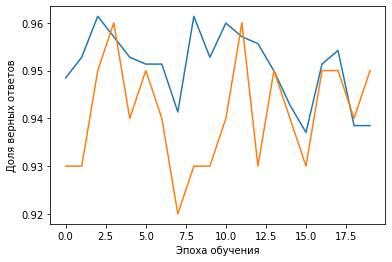

In [ ]:
#обучение
history_s = suit_card_model.fit_generator(
    suit_train_gen,
    steps_per_epoch = suit_train_gen.samples // batch_size_s,
    validation_data = suit_val_gen,
    validation_steps = suit_val_gen.samples // batch_size_s,
    epochs = 20,
    callbacks = [suit_callback],
    verbose = 1
)


plt.plot(history_s.history['accuracy'], label = 'Точность при обучении')
plt.plot(history_s.history['val_accuracy'], label = 'Точность при проверке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.show()

In [ ]:
#suit_card_model.save_weights('/content/drive/MyDrive/model_suit/suit_card_model+lr0.0000001.h5')
#suit_card_model.load_weights('/content/drive/MyDrive/model_suit/next2-suit-weights-11-0.980000+lr.h5')
suit_card_model.load_weights('/content/drive/MyDrive/model_suit/suit-weights-28-0.950000+mix.h5')

In [ ]:
import re

In [ ]:
#Изменю функцию которая выше, чтобы выход функции был предикт карты полностью
def what_card(name_card, model_r,model_s,img_height = 110,img_width = 76, channel = 3):
  img = image.load_img(name_card,target_size = (img_height, img_width,channel))
  np_img = np.array(img) / 255
  plt.imshow(np_img)
  plt.show()  
  
  rang_list = ['6','7','8','9','10','J','Q','K','A']
  suit_list = ['club','diamond','heart','spade']
  cards = []

  #Predict rang
  predict_rang = model_r.predict(np_img[None,])[0]  
  rang = rang_list[np.argmax(predict_rang)]

  tmp = predict_rang[np.argmax(predict_rang)]
  if tmp <0.91:
    print('Это достоинство карты ниже 90%.')  
  print('Ранг карты в цифре из argmaxa: ',tmp)
  print()


  #Predict suit
  predict_suit = model_s.predict(np_img[None,])[0]
  suit = suit_list[np.argmax(predict_suit)]

  tmp_s = predict_suit[np.argmax(predict_suit)]
  if tmp_s <0.91:
    print('Эта масть карты по распознаванию ниже 90%.')  
  print('Масть карты в цифре из argmaxa: ',tmp_s)
  print()
  
  # ok = 0
  # not_ok = 0
  #Совмещаю
  #######
  name_card = name_card.split('/')
  name_card = name_card[3]
  ########
  name_card = name_card.split('.')[0]
  card = rang + '_' + suit
  print('Правильное имя карты: '+ name_card + ' и ' + 'Распознаное имя карты: ' + card)
  if name_card == card:
    #ok += 1
    cards.append(card)    
    print('Карта распознана на ', round((tmp + tmp_s)/2*100),'%')
  else:
    #not_ok += 1
    print('Ошибка карта распознана неправильно')
    

  
 
  #print(cards)
  return cards

In [ ]:
!unzip -q '/content/drive/MyDrive/карты_тест.zip' -d /content/
path_c = '/content/карты_тест/'
#cards = []

In [ ]:
cards = []

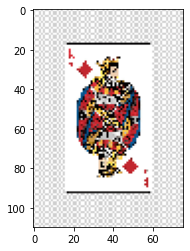

Это достоинство карты ниже 90%.
Ранг карты в цифре из argmaxa:  0.62771165

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.5699218

Правильное имя карты: K_diamond и Распознаное имя карты: Q_club
Ошибка карта распознана неправильно


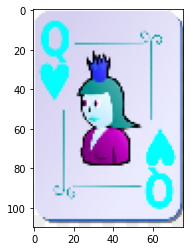

Ранг карты в цифре из argmaxa:  0.99992836

Масть карты в цифре из argmaxa:  0.96033186

Правильное имя карты: Q_heart и Распознаное имя карты: A_club
Ошибка карта распознана неправильно


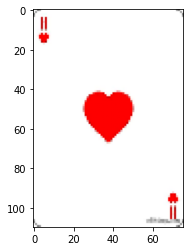

Ранг карты в цифре из argmaxa:  1.0

Масть карты в цифре из argmaxa:  0.9993954

Правильное имя карты: A_heart и Распознаное имя карты: A_heart
Карта распознана на  100 %


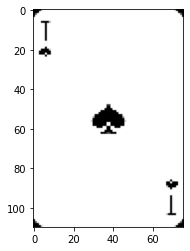

Ранг карты в цифре из argmaxa:  1.0

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.5489622

Правильное имя карты: A_spade и Распознаное имя карты: A_spade
Карта распознана на  77 %


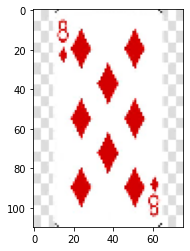

Ранг карты в цифре из argmaxa:  1.0

Масть карты в цифре из argmaxa:  0.9999484

Правильное имя карты: 8_diamond и Распознаное имя карты: 8_diamond
Карта распознана на  100 %


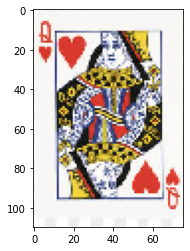

Ранг карты в цифре из argmaxa:  0.99998236

Масть карты в цифре из argmaxa:  0.99995995

Правильное имя карты: Q_heart и Распознаное имя карты: Q_heart
Карта распознана на  100 %


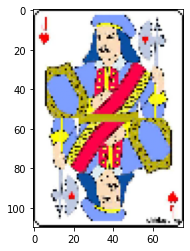

Это достоинство карты ниже 90%.
Ранг карты в цифре из argmaxa:  0.66849923

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.7790749

Правильное имя карты: J_heart и Распознаное имя карты: J_heart
Карта распознана на  72 %


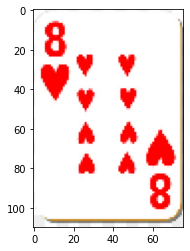

Ранг карты в цифре из argmaxa:  0.99881494

Масть карты в цифре из argmaxa:  0.99999475

Правильное имя карты: 8_heart и Распознаное имя карты: 8_heart
Карта распознана на  100 %


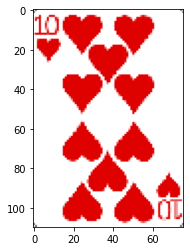

Ранг карты в цифре из argmaxa:  0.9999995

Масть карты в цифре из argmaxa:  1.0

Правильное имя карты: 10_heart и Распознаное имя карты: 10_heart
Карта распознана на  100 %


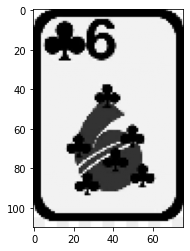

Это достоинство карты ниже 90%.
Ранг карты в цифре из argmaxa:  0.8925229

Масть карты в цифре из argmaxa:  0.91829383

Правильное имя карты: 6_club и Распознаное имя карты: A_club
Ошибка карта распознана неправильно


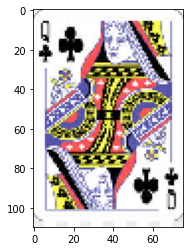

Ранг карты в цифре из argmaxa:  0.99999845

Масть карты в цифре из argmaxa:  0.9916221

Правильное имя карты: Q_club и Распознаное имя карты: Q_club
Карта распознана на  100 %


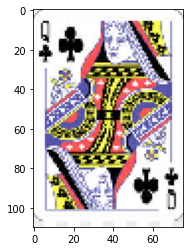

Ранг карты в цифре из argmaxa:  0.99999845

Масть карты в цифре из argmaxa:  0.9916221

Правильное имя карты: Q_club и Распознаное имя карты: Q_club
Карта распознана на  100 %


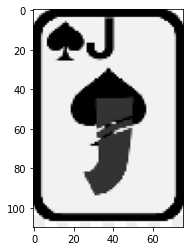

Ранг карты в цифре из argmaxa:  0.9771174

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.81916875

Правильное имя карты: J_spade и Распознаное имя карты: A_spade
Ошибка карта распознана неправильно


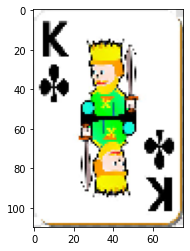

Это достоинство карты ниже 90%.
Ранг карты в цифре из argmaxa:  0.89780194

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.5318552

Правильное имя карты: K_club и Распознаное имя карты: K_club
Карта распознана на  71 %


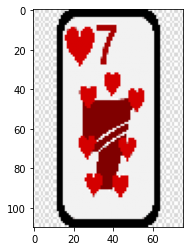

Это достоинство карты ниже 90%.
Ранг карты в цифре из argmaxa:  0.8663166

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.8441331

Правильное имя карты: 7_heart и Распознаное имя карты: A_club
Ошибка карта распознана неправильно


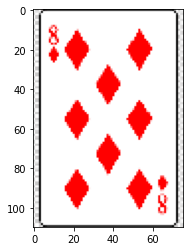

Ранг карты в цифре из argmaxa:  1.0

Масть карты в цифре из argmaxa:  0.9999932

Правильное имя карты: 8_diamond и Распознаное имя карты: 8_diamond
Карта распознана на  100 %


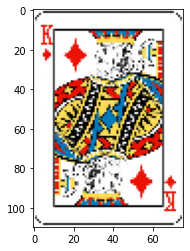

Ранг карты в цифре из argmaxa:  0.9988041

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.7056313

Правильное имя карты: K_diamond и Распознаное имя карты: K_diamond
Карта распознана на  85 %


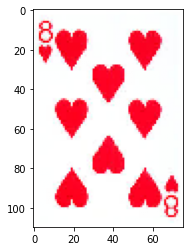

Ранг карты в цифре из argmaxa:  0.9999987

Масть карты в цифре из argmaxa:  1.0

Правильное имя карты: 8_heart и Распознаное имя карты: 8_heart
Карта распознана на  100 %


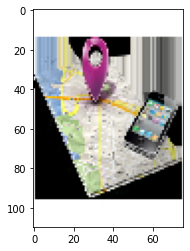

Это достоинство карты ниже 90%.
Ранг карты в цифре из argmaxa:  0.7021477

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.4686241

Правильное имя карты: X_X и Распознаное имя карты: J_spade
Ошибка карта распознана неправильно


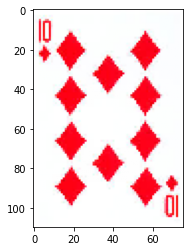

Ранг карты в цифре из argmaxa:  1.0

Масть карты в цифре из argmaxa:  1.0

Правильное имя карты: 10_diamond и Распознаное имя карты: 10_diamond
Карта распознана на  100 %


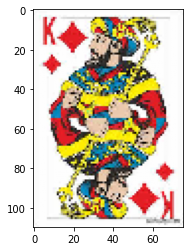

Ранг карты в цифре из argmaxa:  0.99973565

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.5754132

Правильное имя карты: K_dialmond и Распознаное имя карты: K_diamond
Ошибка карта распознана неправильно


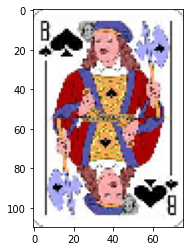

Ранг карты в цифре из argmaxa:  0.94962627

Эта масть карты по распознаванию ниже 90%.
Масть карты в цифре из argmaxa:  0.80490714

Правильное имя карты: J_spade и Распознаное имя карты: J_club
Ошибка карта распознана неправильно
[[], [], ['A_heart'], ['A_spade'], ['8_diamond'], ['Q_heart'], ['J_heart'], ['8_heart'], ['10_heart'], [], ['Q_club'], ['Q_club'], [], ['K_club'], [], ['8_diamond'], ['K_diamond'], ['8_heart'], [], ['10_diamond'], [], []]


In [ ]:
for i in os.listdir(path_c):
  card = what_card(path_c + str(i),rang_card_model,suit_card_model)
  cards.append(card)
print(cards)